# DSCI 100 Project Final Report – Group Component

Created by Chrissy DIng, Kaylee Hogeboom, Rhett Cotton, and Trinity Chan

### 1. Introduction

#### The addressed broad question: "We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts"

#### Specifc Question: Can age and experience predict the total hours played so we can target similar players for large-data recruitment?
Using provided datasets, we'll investigate this question for Frank Wood's CS research group's game, PLAICraft. The main dataset used will be players.csv.


#### Pre-Inspection Details

The dataset that we will use for our analysis comes from the Pacific Laboratory for Artificial Intelligence (PLAI), which is a part of the Department of Computer Science at UBC; the Minecraft server they run is aptly named PLAICraft. Their mission is to create ethical generative AI systems that will have a lasting positive impact on society. Through the collection of data from this Minecraft server, PLAI aims to create an advanced embodied AI which can interact with real people. All of this is done by training an AI model on the thousands of hours of behavioural data of the players of this server.
\
To ensure the data collected proves useful and is able to be easily analyzed, PLAICraft has certain rules that must be followed. The main rules are as follows below:

>- If you are away from keyboard (AFK) for more than 5 minutes you will be removed from the server
>- All voice chat must be spoken in English
>- Please remember to play in a quiet environment without background noise
>- Please be sure to enter gameplay within 10 minutes of requesting a session

As well, players must be generally respectful, they must not use any hacks or cheats while playing, and they must refrain from destroying other players' works. If players do not follow the above rules, their data is discarded and they are removed from the server. Finally, to ensure resources are not wasted, if players request a session and then do not show up (ie. log in to the server) within 10 minutes, they incur a time penalty during which they cannot join the server. This time penalty increases as players continue to fail to show up for requested sessions, with a maximum penalty of 125 hours before players can next join the server.

Furthermore, PLAI encourages players to interact with each other via in-game voice chat, and they encourage players to invite their friends. Both of these are incentivized by additional playtime if players participate. Otherwise, players are allowed to play on the server for 3 minutes every hour they're away, up to a maximum of 30 minutes. As for the datasets we are concerned with for this analysis, their data was collected between May 1st, 2024 and September 1st, 2024. The sessions were tracked from the time the game browser was opened until it was closed by the players, which are recorded in **sessions.csv**. There are two NA values in **players.csv**, for which we kept because other variables in those rows may be valuable for exploratory visualizations and summaries.

\
As for the ethics involved, PLAI has received permission to run this study from the Office of Research Ethics at UBC, and they require a consent form (or parental consent) for players to access the server. Emails and phone numbers are collected to send links to players to allow them access to the server, as well as if a player's data needs to be deleted for any reason. PLAI states that they track gameplay, speech, and key presses in the PLAICraft Minecraft browser window. If for any reason a player wishes for part of their data to be excluded from collection, they are able to email support@plaicraft.ai
 for assistance. This is also the email to which players should write to if they wish to report technical problems or abuses from other players. Now we will begin our analysis of the **players.csv** dataset. 

In [3]:
# First, let's load in some R packages!
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(tidymodels)
library(gridExtra)

#### i) Data Descriptions and Inspecting the Datasets with R Functions and Summaries

In [4]:
# load the dataset we'll be working with
url_players <- "https://raw.githubusercontent.com/tchan0717/dsci-100-2025w1-group-36/refs/heads/main/data/players.csv"
players <- read_csv(url_players)

head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


#### Description of the set (players.csv):

- 196 observations, 7 variables about the players:
1. `experience`: *character* - gaming "level" - order from least to most experienced: Beginner, Amateur, Regular, Veteran, Pro
2. `subscribe`: *logical* - PlaiCraft newsletter subscription: TRUE="yes", FALSE="no"
3. `hashedEmail`: *character* - email formatted in numbers and letters
4. `played_hours`: *double* - total hours played
5. `name`: *character* - first name
6. `gender`: *character* - gender
7. `age`: *double* - age (years)

##### Issues: 
- `subscribe` is ambiguous - likely indicates newsletter subscription
- `experience` "level" order is unclear
    - The assumed order is stated above, but there is no metadata to verify this
 
Tidy data follows one variable per column, one observation per row, and one value per cell. Wrangling isn't needed as the dataset follows this.

In [5]:
# Now, let's read in sessions.csv!
url_sessions <- "https://raw.githubusercontent.com/tchan0717/dsci-100-2025w1-group-36/refs/heads/main/data/sessions.csv"
sessions <- read_csv(url_sessions)
head(sessions)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


#### Description of the set (sessions.csv):

- 1535 observations, 5 variables:
1. `hashedEmail`: *character* - email formatted in numbers and letters
2. `start_time`: *character* - session start time (DD/MM/YYYY", "time (24-hour-clock)")
4. `end_time`: *character* - session end time ("DD/MM/YYYY", "time (24-hour-clock)")
5. `original_start_time`: *double* - session start time in UNIX (milliseconds)
6. `original_end_time`: *double* - session end time in UNIX (milliseconds)

This dataset isn't the focus, but beneficial for further exploratory visualizations. It's already tidy as well.

In [11]:
# We will merge the datasets together as well to simplify future explorations:
sessions_players_merged <- merge(players, sessions, by = "hashedEmail", all = TRUE)
head(sessions_players_merged)

,hashedEmail,experience,subscribe,played_hours,name,gender,Age,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Isaac,Male,20,23/05/2024 00:22,23/05/2024 01:07,1.71642e+12,1.71643e+12
2,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Isaac,Male,20,22/05/2024 23:12,23/05/2024 00:13,1.71642e+12,1.71642e+12
3,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Veteran,TRUE,0.0,Frankie,Male,17,NA,NA,NA,NA
4,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,FALSE,0.4,Lyra,Male,21,28/06/2024 04:28,28/06/2024 04:58,1.71955e+12,1.71955e+12
5,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,TRUE,0.1,Osiris,Male,17,19/09/2024 21:01,19/09/2024 21:12,1.72678e+12,1.72678e+12
6,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,TRUE,5.6,Winslow,Male,17,30/08/2024 03:40,30/08/2024 04:04,1.72499e+12,1.72499e+12


### 2. Methods & Results

This section will include summaries and exploratory visualizations of the dataset, the creation of the model, and visualizations based on the final data analysis.

#### Summary #1 - Experience

In [12]:
experience_count <- players |>
                        group_by(experience) |>
                        summarize(count = n())

experience_summary <- experience_count |>
                        ungroup() |>
                        mutate(percent_of_overall_dataset = count/sum(count) * 100) |> 
                        mutate(percent_of_overall_dataset = round(percent_of_overall_dataset, 2)) #round to 2 decimal places
experience_summary

experience,count,percent_of_overall_dataset
<chr>,<int>,<dbl>
Amateur,63,32.14
Beginner,35,17.86
Pro,14,7.14
Regular,36,18.37
Veteran,48,24.49


#### Summary #2 - Played Hours

In [13]:
played_hours_summary <- players |>
                            summarize(mean = mean(played_hours, na.rm = TRUE),
                                      sum = sum(played_hours, na.rm = TRUE),
                                      most = max(played_hours),
                                      least = min(played_hours)) |>
                            mutate(across(mean:least, ~ round(.x, 2)))    
played_hours_summary       

mean,sum,most,least
<dbl>,<dbl>,<dbl>,<dbl>
5.85,1145.8,223.1,0


#### Summary #3 - Age (Years)

In [14]:
age_summary <- players |>
                    summarize(mean = mean(Age, na.rm = TRUE),
                              oldest = max(Age, na.rm = TRUE),
                              youngest = min(Age, na.rm = TRUE)) |>
                    mutate(across(mean:youngest, ~ round(.x, 2)))    
age_summary   

mean,oldest,youngest
<dbl>,<dbl>,<dbl>
21.14,58,9


#### Summary #4 - Total Sessions

In [15]:
total_sessions_count <- sessions |>
                                group_by(hashedEmail) |>
                                summarize(count = n())

total_sessions_summary <- total_sessions_count |>
                                summarize(mean = mean(count, na.rm = TRUE),
                                      median = median(count, na.rm = TRUE),
                                      most = max(count),
                                      least = min(count)) |>
                                mutate(across(mean:least, ~ round(.x, 2)))  
total_sessions_summary

mean,median,most,least
<dbl>,<dbl>,<dbl>,<dbl>
12.28,1,310,1


#### ii) Exploratory Data Analysis and Visualization

Let's create some visualizations to seek out any relevant relationships and overlooked issues.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


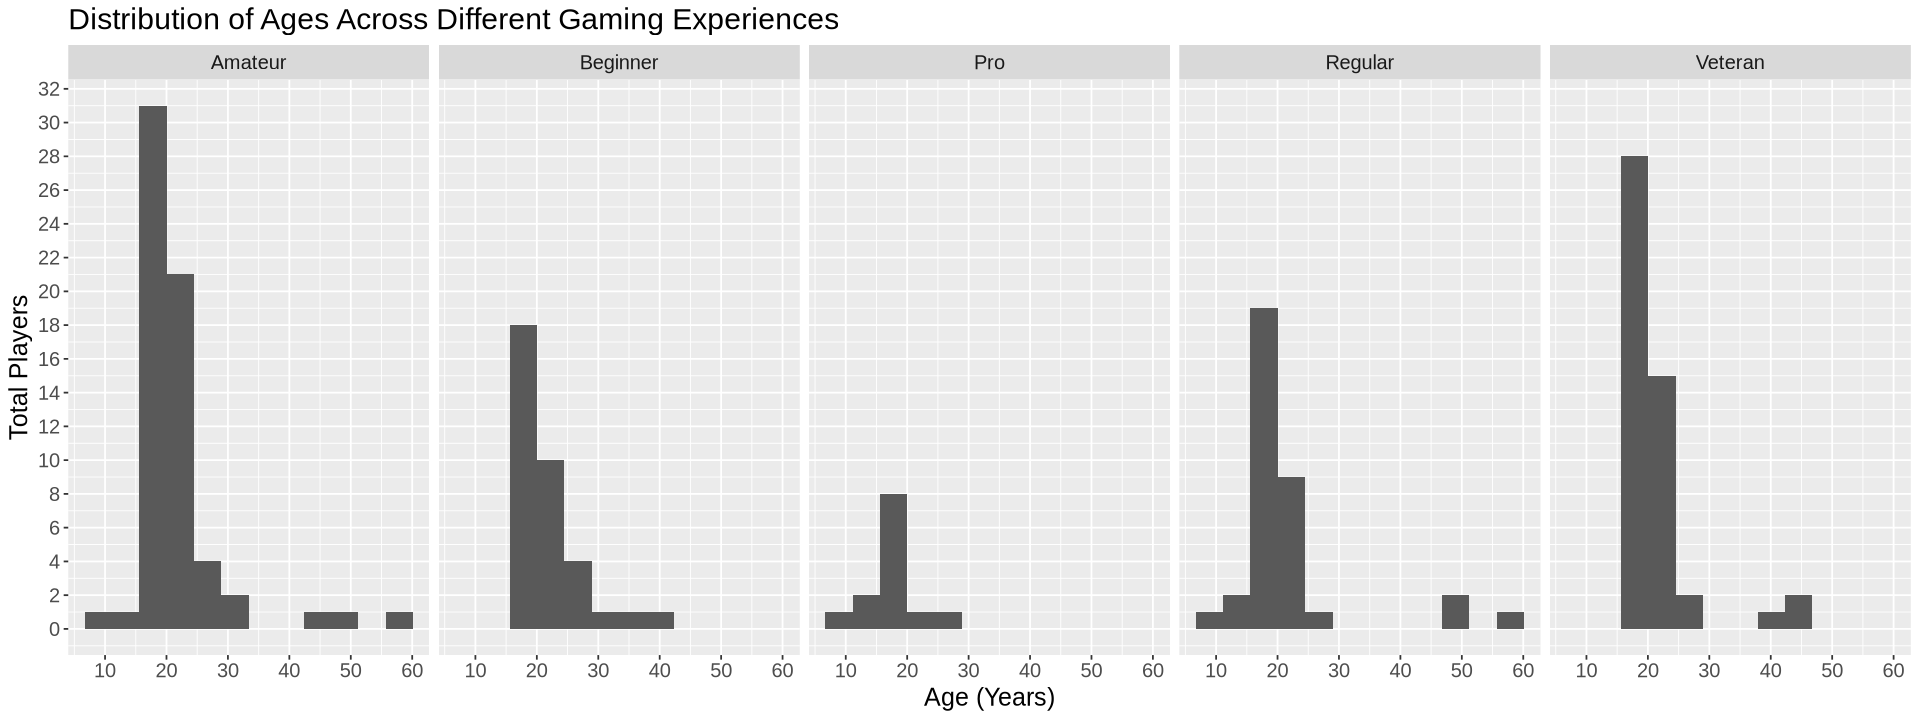

In [16]:
options(repr.plot.width = 16, repr.plot.height = 6)

age_histogram <- ggplot(players, aes(x = Age)) +
                    geom_histogram(bins = 12) +
                    labs(x = "Age (Years)", y = "Total Players") +
                    ggtitle("Distribution of Ages Across Different Gaming Experiences") +
                    scale_y_continuous(breaks = seq(0, 32, by = 2)) +
                    scale_x_continuous(breaks = seq(0, 60, by = 10)) +
                    facet_grid(cols = vars(experience)) +
                    theme(text = element_text(size = 15))
age_histogram

#### Figure 1. Bar plots of varying ages across gaming experiences

The majority of players are approximately 17 years old. There are numerous teenagers and young adults who participated in the study, though relatively few children and older adults. By the class observations, there are many amateurs and veterans. Additionally, from these plots, we can conclude that age does not equate to gaming experience.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


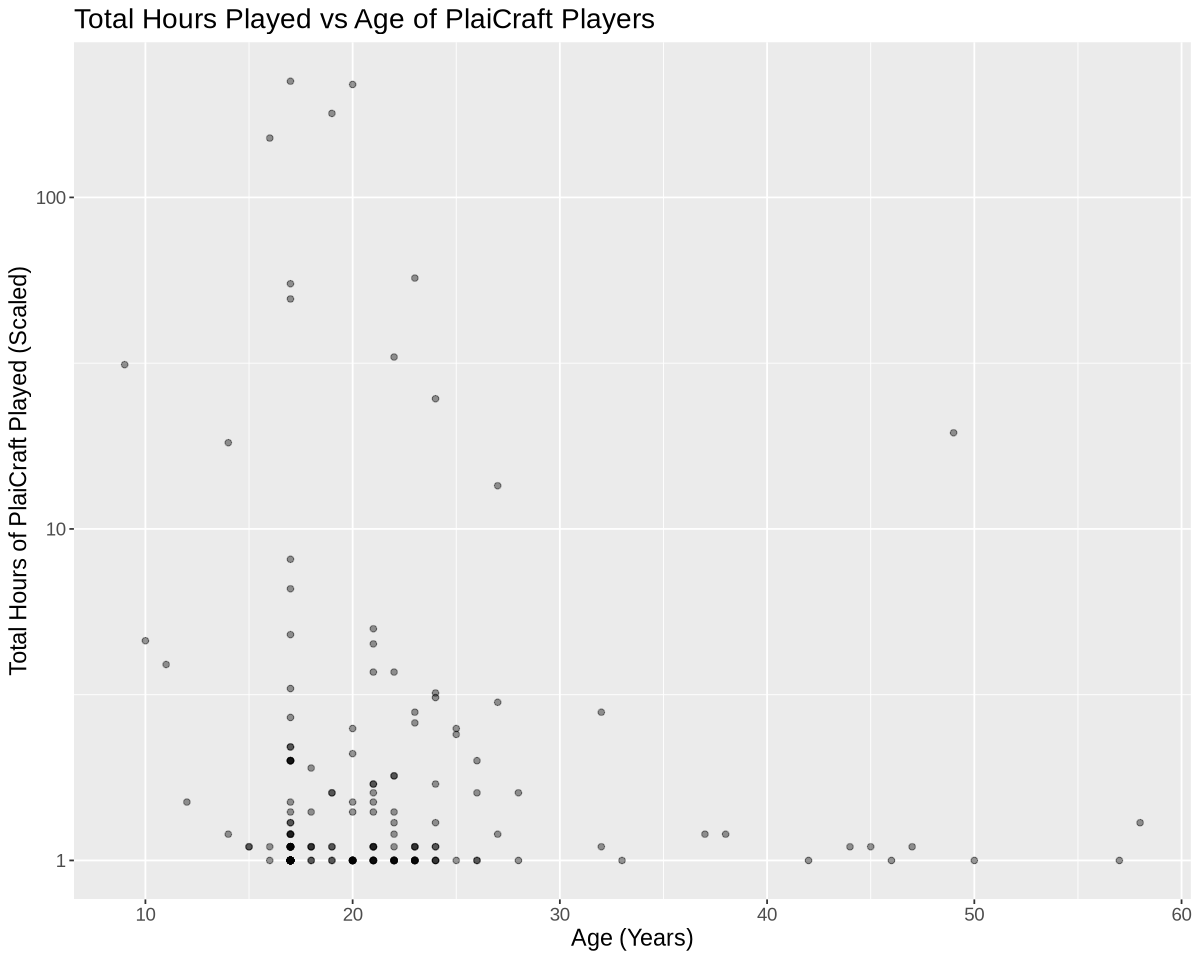

In [17]:
options(repr.plot.width = 10, repr.plot.height = 8)

played_hours_age_plot <- ggplot(players, aes(x = Age, y = played_hours + 1)) + #add +1 so that when we log our y-axis, the 0 values won't be infinity
                            geom_point(alpha = 0.4) +
                            labs(x = "Age (Years)", y = "Total Hours of PlaiCraft Played (Scaled)") +
                            ggtitle("Total Hours Played vs Age of PlaiCraft Players") +
                            scale_y_log10() +
                            theme(text = element_text(size = 14))
played_hours_age_plot

#### Figure 2. Scatter plot of total hours played vs age of the players

From this plot, there is no clear relationship or trend, as the points are very spread out and seemingly unordered. However, there are some points condensed near the bottom of the graph. This implies that teenagers and young adults play the game more. Though, due to the spread of the points, this is likely also player-dependent.


`summarise()` has grouped output by 'hashedEmail', 'played_hours'. You can
override using the `.groups` argument.


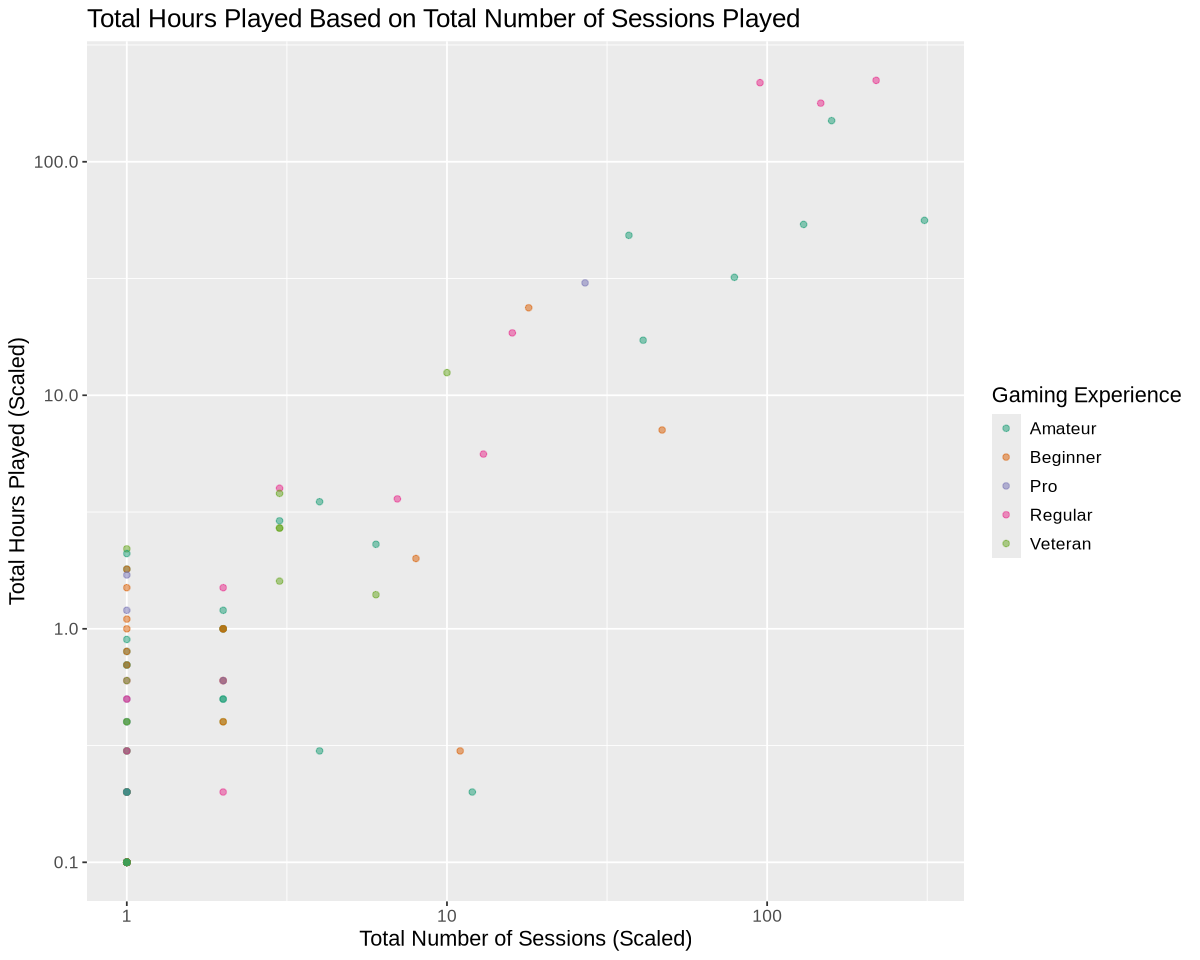

In [18]:
options(repr.plot.width = 10, repr.plot.height = 8)

sessions_hours_total <- sessions_players_merged |>
                        select(hashedEmail, played_hours, experience) |>
                        filter(played_hours != 0) |>
                        group_by(hashedEmail, played_hours, experience) |>
                        summarize(count = n()) #summarizing how many sessions each player played

experience_sessions_plot <- sessions_hours_total |>
                        ggplot(aes(x = count, y = played_hours, color = experience)) +
                            geom_point(alpha = 0.5) +
                            labs(x = "Total Number of Sessions (Scaled)", y = "Total Hours Played (Scaled)", colour = "Gaming Experience") +
                            ggtitle("Total Hours Played Based on Total Number of Sessions Played") +
                            scale_color_brewer(palette = "Dark2") +
                            scale_y_log10() +
                            scale_x_log10() +
                            theme(text = element_text(size = 13))
experience_sessions_plot                        

#### Figure 3. Scatter plot of total hours played vs total sessions played with gaming experiences noted by colour

There is a moderately strong to weak positive relationship in this plot, as the variables increase together. Players who play the same number of sessions do not necessarily play the same number of hours. As well, the gaming experience is rather scattered across this chart, suggesting a weaker relationship between experience and hours/sessions played. Notably, some regulars and amateurs played the greatest number of sessions and the most hours.

#### iii) KNN Regression Model and Data Analysis

Now, let's make the regression model! The steps we will follow are outlined below:

1. Mutate **experience** into numerical values
2. Inspect and clean data (eg. handle NA values)
3. Split dataset
      - 75% training, 25% testing
4. Tune training set
      - Scale predictors
5. Cross-validate training set
      - 5 folds
      - Tested neighbors differ by 3; neighbors = 1,4,..100
6. Find optimal **K-value**, refit model, assess on testing data for RMSPE

In [19]:
# Step 1 and 2
players_tidy <- players |>
                    mutate(experience = factor(experience,
                           levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
                           ordered = TRUE),
                           experience_num = as.numeric(experience)) |>
                           select(played_hours, experience_num, experience, Age) |>
                           na.omit(played_hours)
head(players_tidy)

played_hours,experience_num,experience,Age
<dbl>,<dbl>,<ord>,<dbl>
30.3,5,Pro,9
3.8,4,Veteran,17
0.0,4,Veteran,17
0.7,2,Amateur,21
0.1,3,Regular,21
0.0,2,Amateur,17


In [21]:
# Step 3 and 4
set.seed(1234)
players_split <- initial_split(players_tidy, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("regression")

players_recipe <- recipe(played_hours ~ experience_num + Age, data = players_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

players_workflow <- workflow() |>
                        add_recipe(players_recipe) |>
                        add_model(players_spec)
players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [22]:
# Step 5
set.seed(1234)
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_results <- players_workflow |>
                        tune_grid(resamples = players_vfold, grid = gridvals) |>
                        collect_metrics() |>
                        filter(.metric == "rmse")
head(players_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,40.91332,5,8.063748,Preprocessor1_Model01
4,rmse,standard,34.94656,5,5.528236,Preprocessor1_Model02
7,rmse,standard,29.47816,5,5.794990,Preprocessor1_Model03
10,rmse,standard,30.33832,5,5.574974,Preprocessor1_Model04
13,rmse,standard,29.71904,5,6.230914,Preprocessor1_Model05
16,rmse,standard,29.89624,5,5.985292,Preprocessor1_Model06


In [23]:
set.seed(1234)
players_min <- players_results |>
                    slice_min(mean, n = 1) #this shows the best "k" to use
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
100,rmse,standard,28.61884,5,7.86778,Preprocessor1_Model34


In [24]:
# Step 6
set.seed(1234)
k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,11.301323152
rsq,standard,0.004898366
mae,standard,9.753510204


In [34]:
# Final model
set.seed(1234)
players_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 100) |>
                        set_engine("kknn") |>
                        set_mode("regression")

players_recipe_final <- recipe(played_hours ~ experience_num + Age, data = players_tidy) |>
                            step_center(all_predictors()) |>
                            step_scale(all_predictors())

players_fit_final <- workflow() |>
                        add_recipe(players_recipe_final) |>
                        add_model(players_spec_final) |>
                        fit(players_tidy)

#### iv) Trying the Model With New Observations

In [35]:
set.seed(1234)
new_obs <- tibble(Age = sample(5:58, size = 196, replace = TRUE),
                  experience_num = sample(1:5, size = 196, replace = TRUE))

predict_new_obs <- players_fit_final |>
                    predict(new_obs) |>
                    bind_cols(new_obs) 

head(predict_new_obs)

.pred,Age,experience_num
<dbl>,<int>,<int>
6.620,32,2
7.429,20,3
8.011,26,2
5.801,41,3
5.805,48,4
5.805,51,3


#### v) Visualizations of Model and Analysis

The following visualizations will be further discussed and compared in the "Discussion" section.

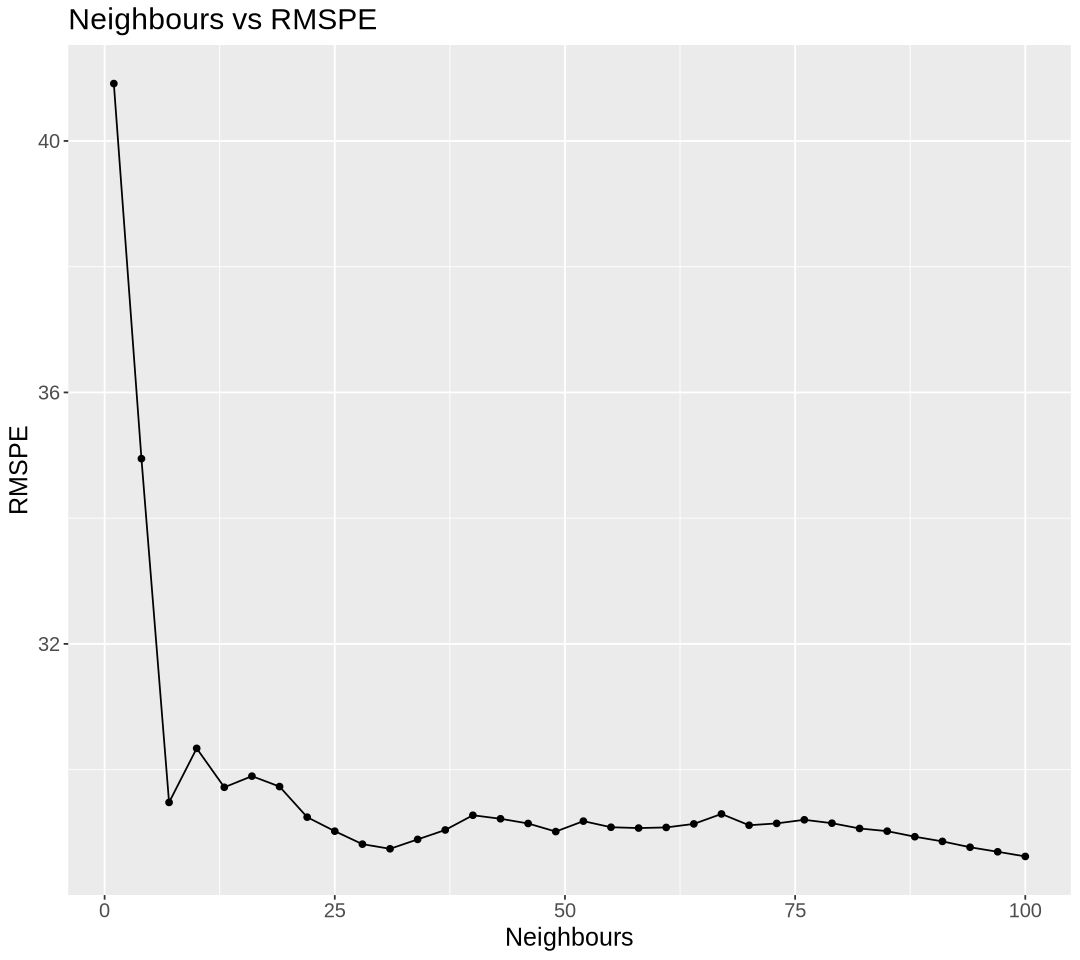

In [36]:
options(repr.plot.width = 9, repr.plot.height = 8)
k_rmspe_plot <- players_results |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbours", y = "RMSPE") +
                    ggtitle("Neighbours vs RMSPE") +
                    theme(text = element_text(size = 15))
k_rmspe_plot

#### Figure 4. Graph of various *k* neighbours and their RMSPE values

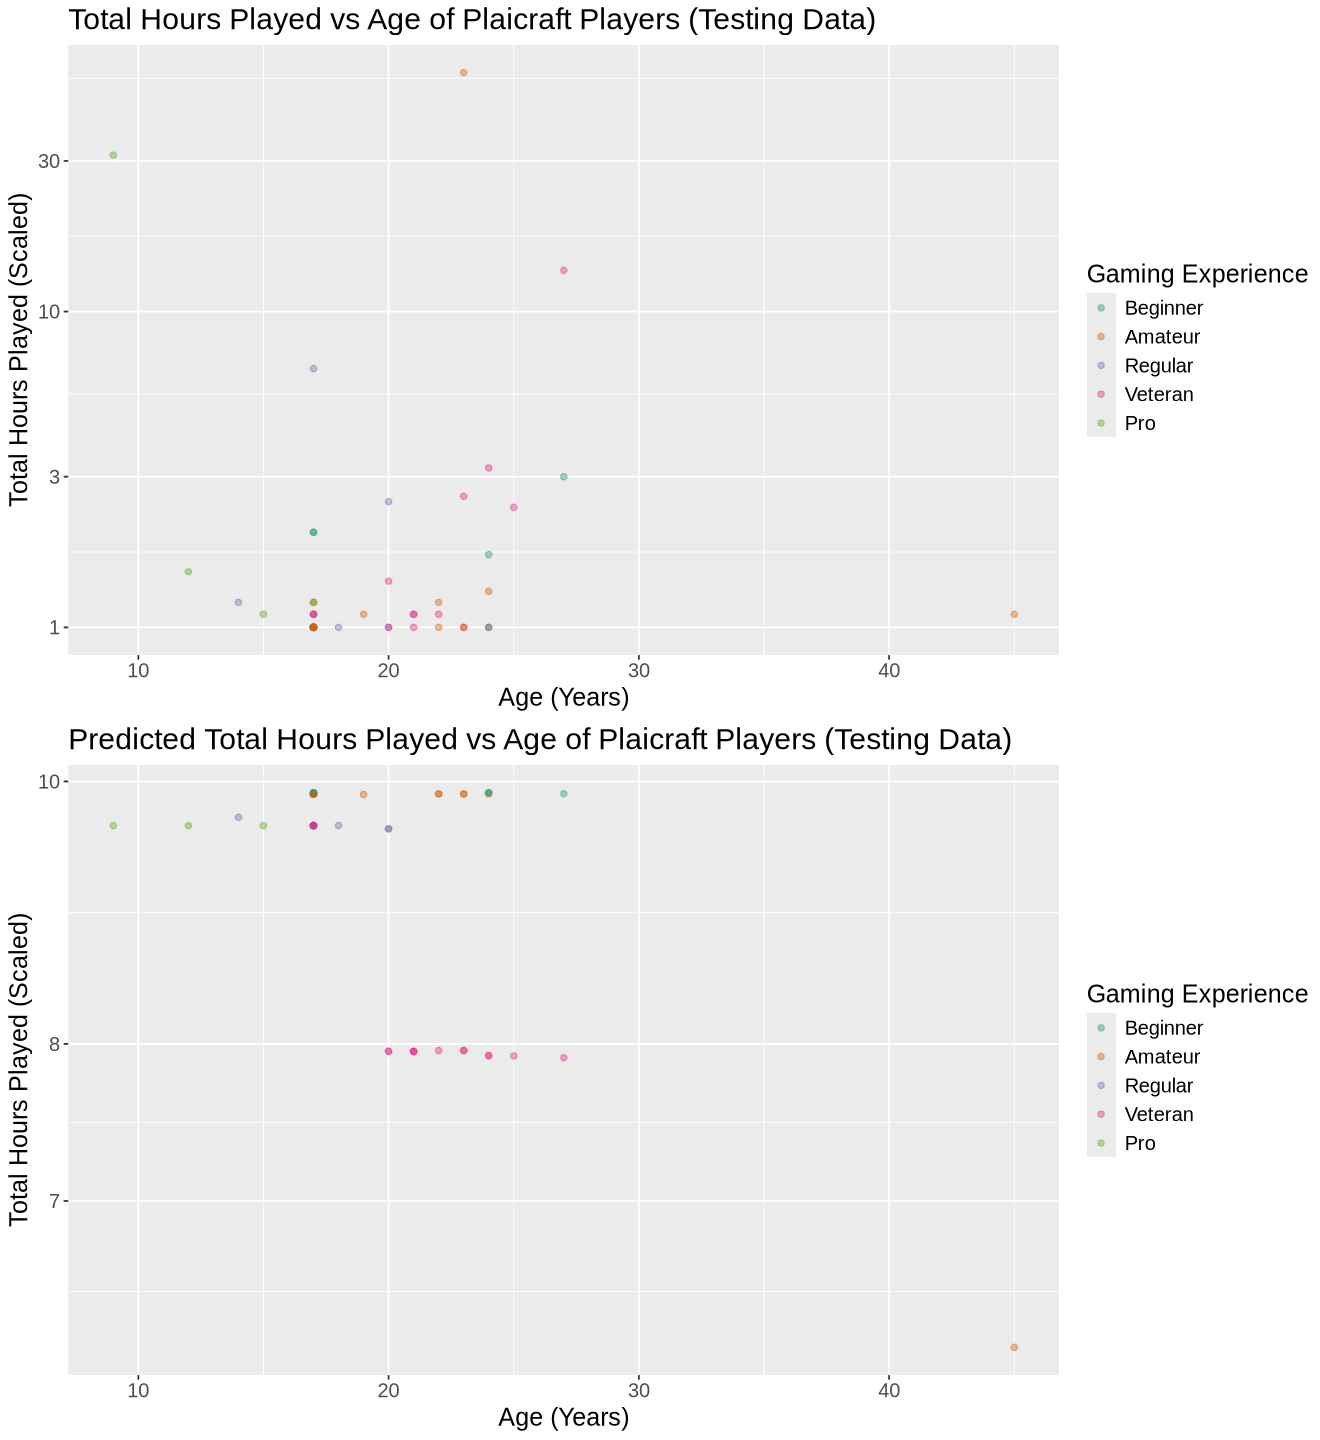

In [38]:
set.seed(1234)
options(repr.plot.width = 11, repr.plot.height = 12)
testing_data_plot <- players_testing |>
                            ggplot(aes(x = Age, y = played_hours + 1, colour = experience)) +
                            geom_point(alpha = 0.4) + 
                            labs(x = "Age (Years)", y = "Total Hours Played (Scaled)", colour = "Gaming Experience") +
                            ggtitle("Total Hours Played vs Age of Plaicraft Players (Testing Data)") +
                            scale_color_brewer(palette = "Dark2") +
                            scale_y_log10() +
                            theme(text = element_text(size = 15))

testing_preds <- players_best_fit |>
  predict(players_testing) |>
  bind_cols(players_testing)

predicted_testing_plot <- ggplot(testing_preds, aes(x = Age, y = .pred, colour = experience)) +
                              geom_point(alpha = 0.4) +
                              labs(x = "Age (Years)", y = "Total Hours Played (Scaled)", colour = "Gaming Experience") +
                              ggtitle("Predicted Total Hours Played vs Age of Plaicraft Players (Testing Data)") +
                              scale_color_brewer(palette = "Dark2") +
                              scale_y_log10() +
                              theme(text = element_text(size = 15))

grid.arrange(testing_data_plot, predicted_testing_plot)

#### Figure 5. Scatter plot comparison of the actual testing data and the predictions of the testing data made by the model

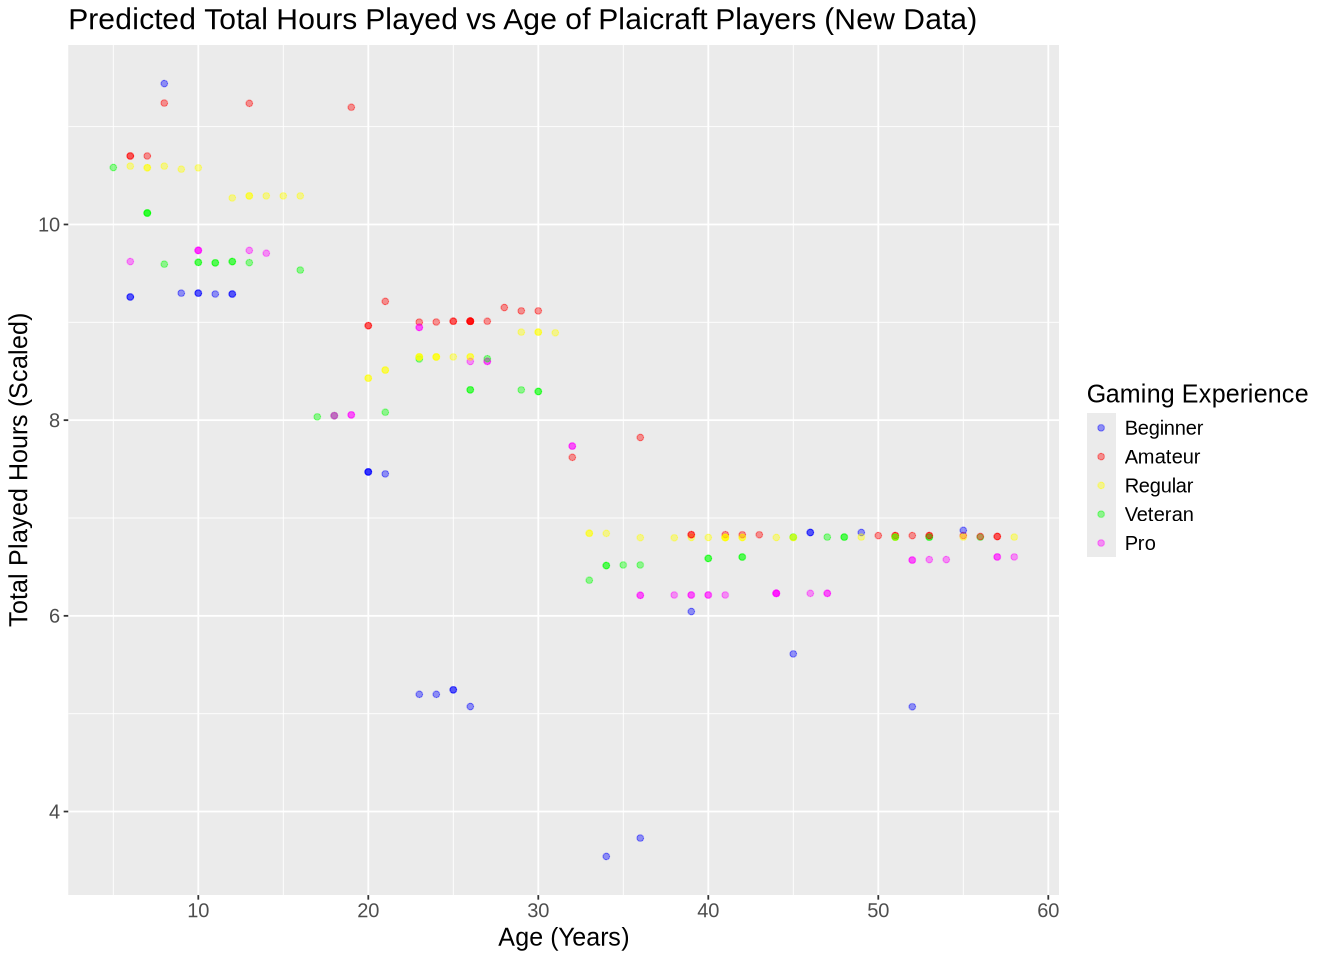

In [33]:
options(repr.plot.width = 11, repr.plot.height = 8)
new_obs_plot <- predict_new_obs |>
                    ggplot(aes(x = Age, y = .pred + 1, colour = factor(experience_num))) +
                    geom_point(alpha = 0.4) +
                    labs(x = "Age (Years)", y = "Total Played Hours (Scaled)", colour = "Gaming Experience") +
                    ggtitle("Predicted Total Hours Played vs Age of Plaicraft Players (New Data)") +
                    scale_color_manual(values = c("1" = "blue", "2" = "red", "3" = "yellow", "4" = "green", "5" = "magenta"),
                                       labels = c("1" = "Beginner", "2" = "Amateur", "3" = "Regular", "4" = "Veteran", "5" = "Pro")) +
                    theme(text = element_text(size = 15))

new_obs_plot

#### Figure 6. Scatter plot of the predictions made by the model for new data

### 3. Discussion

Before discussing our results, let's discuss our predictions and expectations. Based on our exploratory data analysis, in Figure 2 and the data provided, we would expect that younger ages will play the game more and produce higher total hours played as they are generally on technology more. Likewise, in Figure 3, hours played and number of sessions increase together but don't exactly depend on gaming experience. This was expected because players in the same experience level can have very different hours and sessions played. However, there are a few Amateurs who have larger total hours in the graph, so we can anticipate that newer players (amateurs) would log the most total hours played. Based on Figure 1, there are quite a lot of seasoned, competitive players (veterans). We may predict that they would contribute large amounts of data and hours as well. We can deduce that these trends are likely due to the release of dopamine from the anticipation of playing a new game. New players will log more hours played as it will be more interesting and fresh for them. For Veterans, they may log more hours because for many of them, the game is very familiar and even habitual. Professionals and content creators—who would be among veteran players—play many hours to train their skills before tournaments and to stream to audiences in order to monetize their gaming skills and time dedication. Knowing what age range and experience levels play the game the most will let us target those demographics in recruitment efforts.

To begin our discussion on our results, we will refer to Figure 5 where we are comparing graphs of the actual testing data vs. the predictions of the testing data the model made. We can see that the predictions were relatively poor in accuracy. The trends are not that similar, and although gaming experience is scattered, there is a line of points in the predicted graph that corresponds only to veterans instead of a scattered mix of experiences shown in the graph of the actual testing data values above it. This can indicate a poor model. Disregarding this for a moment, after doing a trial run of our model with new observations by creating a tibble with randomized Age and experience_num values, we can see that older players are predicted to most likely play fewer hours of PLAICraft, and they therefore contribute less data than younger players. This is shown visually in Figure 6. Thus, if we were to base our answer to our question just on the model alone, not knowing how well it predicted on the testing data, we may consider recruiting younger players, which follows the trend we expected to find as stated above. According to this figure, there is no concrete trend in the total played hours and experience, as the experiences are scattered. Thus, our expectations of amateurs and veterans contributing the most played hours are not supported by this analysis.

The best k we found is 100, and its RMSPE value is 11.30, as shown in Step 6 of making our model. This suggests that our model predicts values with an error of 11.30 hours. Assessing this error within the context of our question, we can say that it is a fairly large error value. An error of 11 hours can be quite the deciding factor, considering that we are looking for types of players that could contribute large amounts of data. For instance, if a player actually had 30 hours of playtime but was predicted to have 19 hours, we may reconsider recruiting those types of players when in reality they did contribute a decent amount of hours. On the other hand, if a player had 10 hours of playtime but was predicted to have 21 hours, we may consider them for recruitment when they actually didn't contribute as much as we thought.

Some of these aforementioned limitations of our model—and thus this high RMSPE value—likely come from the fact that the dataset contains real, nonfabricated data. There is a high chance for variability among players, and there won't be many strong and consistent patterns or trends seen. In addition, outliers in our dataset may also negatively affect the model's ability to accurately predict hours played, though the extent of this is likely not the cause of the inaccuracy as a whole. The highest amount of total hours played, as seen in Summary #2, was 223 hours, and the mean was 5 hours. If there were many strong outliers, even values in the 100s of hours, it may affect the predictions, as they are based on the 100 closest data points, which is a large range of points. Along the same lines, when k is 100, it is approximately 68% of our original dataset. This could cause some underfitting issues, making our model not influenced enough by the data. Moreover, data imbalance is also likely a problem. As seen in Summary #1, the distribution of experience levels is not even, and pros only make up approximately 7% of the data while the other experiences make up 10–30%, thus contributing to the difficulty our regression model faced when predicting hours played.

A suggestion to make our model better would be to try a smaller range of k values to avoid underfitting. When selecting k, our tuning method deduced that 100 was the value that gave the lowest RMSPE, though the RMSPE appeared to decrease continually as k became greater and greater. As such, it is possible that linear regression could have also been used, though it would be beneficial to test it against a similar k-NN regression model. Furthermore, collecting more data to train our model and increase the frequency of certain experience-level observations, such as pros, would help to create a more even distribution. Primarily, though, this model suffers from a lack of data. More data on which to base our predictions would almost certainly be helpful, as this dataset is quite small, and since the k-value was so high, underfitting was very easy to achieve. With these future changes, it would hopefully guide our model to becoming more accurate and lowering its RMSPE value. Although this model is not perfect, these findings of ours are very impactful and directed us onto the critical-thinking path of considering ways to improve it.

Moreover, this analysis has given our group some time to pose further questions on this dataset as to analyses that could theoretically be done. Below, we have outlined one main question that arose while working with these datasets and what we think it would yield in terms of further understanding:

#### How did the relatively stringent and rigid rules regarding playtime on the server influence the total amount of time that individual players spent on the PLAICraft server?
As outlined in the introduction, there are various rules on the PLAICraft server, one of which is the amount of time that an individual player is able to spend on the server in one session, which is limited to 30 minutes. As such, our group wondered at various times throughout the above analysis how this impacted the amount of time players spent on the server. This is a very direct barrier to playing on the server, and thus contributing data, which, in our opinion, would likely deter some players from actually contributing data by playing. Notably, if there are veteran and pro players of the game, why would they try to go against the barriers to play on this server instead of logging on to another Minecraft server without such restrictions? This could have affected the results as found in Figure 6, which could account for some of the discrepancy between our expectations and the result. To further study this, players who play on a server could be sent a questionnaire in which they rank how different aspects of the server affected how much time they spent playing, as well as how this affects the likelihood that they will subscribe to a game-related newsletter or other recruitment-related services.

### GitHub Repository

https://github.com/tchan0717/dsci-100-2025w1-group-36.git

### References

Wickham, Hadley, and Garrett Grolemund. 2016. R for Data Science: Import, Tidy, Transform, Visualize, and Model Data. O’Reilly. https://r4ds.had.co.nz/.
\
\
The Pacific Laboratory of Artificial Intelligence. FAQ. Plaicraft. https://plaicraft.ai/faq. 